## Configurações de ambiente

In [1]:
import kagglehub
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

/Users/vkz/mini_project_1/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importando os dados

In [2]:
path = kagglehub.dataset_download("ashfakyeafi/cat-dog-images-for-classification")
print("Path to dataset files:", path)

Path to dataset files: /Users/vkz/.cache/kagglehub/datasets/ashfakyeafi/cat-dog-images-for-classification/versions/2


In [3]:
cat_dog_path = os.path.join(path, "cat_dog")

In [4]:
df = pd.read_csv(os.path.join(path, "cat_dog.csv"))

In [5]:
train_df, temp_df = train_test_split(
    df, test_size=0.3, random_state=123, stratify=df["labels"]
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=123, stratify=temp_df["labels"]
)

In [6]:
train_df

,image,labels
59,cat.10287.jpg,0
12053,cat.9651.jpg,0
17514,cat.3148.jpg,0
2196,dog.1143.jpg,1
17095,dog.7476.jpg,1
...,...,...
24659,dog.5208.jpg,1
22308,cat.12201.jpg,0
8709,cat.7046.jpg,0
24760,cat.12172.jpg,0


## Classes e funções úteis

In [7]:
class CatsDogsDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]["image"]
        label = int(self.dataframe.iloc[idx]["labels"])

        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [8]:
transform = transforms.Compose(
    [
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
    ]
)

In [9]:
# Create datasets
train_dataset = CatsDogsDataset(train_df, cat_dog_path, transform=transform)
val_dataset = CatsDogsDataset(val_df, cat_dog_path, transform=transform)
test_dataset = CatsDogsDataset(test_df, cat_dog_path, transform=transform)

In [10]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [11]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)

        self.fc1 = nn.Linear(128 * 17 * 17, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> (32, 74, 74)
        x = self.pool(F.relu(self.conv2(x)))  # -> (64, 36, 36)
        x = self.pool(F.relu(self.conv3(x)))  # -> (128, 17, 17)
        x = x.view(-1, 128 * 17 * 17)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [12]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')

In [13]:
model = SimpleCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Treinando o modelo

In [14]:
# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        predicted = (outputs > 0.5).int()
        correct_train += (predicted == labels.int()).sum().item()
        total_train += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    # Evaluating on validation dataset
    model.eval()
    correct = 0
    val_loss = 0.0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.float().to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            predicted = (outputs > 0.5).int()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)
    print(
        f"Epoch {epoch+1} - Train Loss: {train_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]*100:.2f}%"
    )

Epoch 1 - Train Loss: 0.6506, Val Acc: 69.65%
Epoch 2 - Train Loss: 0.5382, Val Acc: 74.61%
Epoch 3 - Train Loss: 0.4621, Val Acc: 78.13%
Epoch 4 - Train Loss: 0.4001, Val Acc: 79.63%
Epoch 5 - Train Loss: 0.3221, Val Acc: 77.68%
Epoch 6 - Train Loss: 0.2286, Val Acc: 79.95%
Epoch 7 - Train Loss: 0.1205, Val Acc: 80.08%
Epoch 8 - Train Loss: 0.0575, Val Acc: 80.11%
Epoch 9 - Train Loss: 0.0348, Val Acc: 78.51%
Epoch 10 - Train Loss: 0.0296, Val Acc: 79.07%


In [ ]:
# Saving the model and results so we do not have to re-train it everytime
torch.save(model.state_dict(), os.path.join("models", "cat_dog_model_v1.pt"))

with open(os.path.join("reports", "cat_dog_model_v1.pkl"), "wb") as f:
    pickle.dump(
        {
            "train_losses": train_losses,
            "train_accuracies": train_accuracies,
            "val_losses": val_losses,
            "val_accuracies": val_accuracies,
        },
        f,
    )

In [23]:
# Loading the saved model
model = SimpleCNN().to(device)
model_path = os.path.join("models", "cat_dog_model_v1.pt")
model.load_state_dict(torch.load(model_path))
model.eval()

# Loading the saved results
results_path = os.path.join("reports", "cat_dog_model_v1.pkl")
with open(results_path, "rb") as f:
    results = pickle.load(f)

train_losses = results["train_losses"]
train_accuracies = results["train_accuracies"]
val_losses = results["val_losses"]
val_accuracies = results["val_accuracies"]

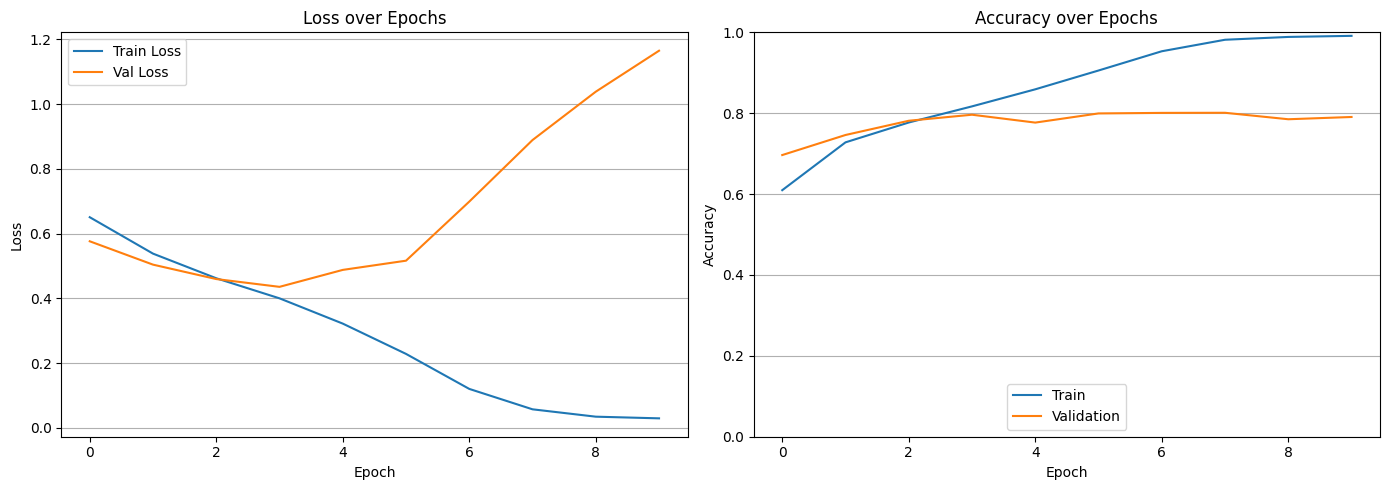

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns

# Loss subplot
axs[0].plot(train_losses, label="Train Loss")
axs[0].plot(val_losses, label="Val Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Loss over Epochs")
axs[0].legend()
axs[0].grid(True, axis="y")

# Accuracy subplot
axs[1].plot(train_accuracies, label="Train")
axs[1].plot(val_accuracies, label="Validation")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Accuracy over Epochs")
axs[1].legend(loc="lower center")
axs[1].set_ylim(0, 1)
axs[1].grid(True, axis="y")

plt.tight_layout()
plt.show()

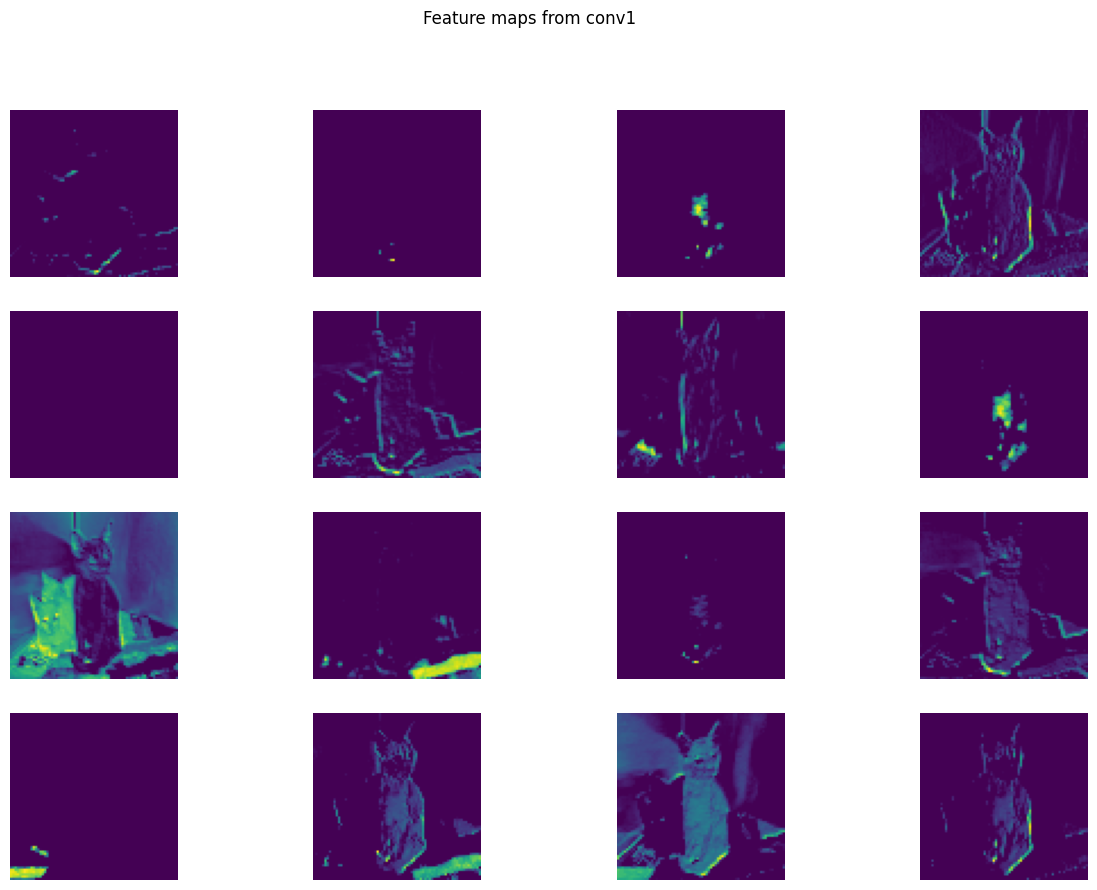

In [25]:
def visualize_feature_maps(model, image_tensor):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        x = model.conv1(image_tensor)
        x = model.pool(F.relu(x))

    feature_maps = x.squeeze(0).cpu()
    num_maps = feature_maps.shape[0]

    plt.figure(figsize=(15, 10))
    for i in range(min(num_maps, 16)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(feature_maps[i], cmap="viridis")
        plt.axis("off")
    plt.suptitle("Feature maps from conv1")
    plt.show()


# Use uma imagem do dataset
sample_image, _ = next(iter(test_loader))
visualize_feature_maps(model, sample_image[0])

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = (outputs > 0.5).int().squeeze()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 79.55%
